## 1. Import the libraries and prepare the dataset

The process of how a model is selected begins like this,


<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="350" height="auto" />

(Source: [scikit-learn.org, n.d.](https://scikit-learn.org/stable/modules/cross_validation.html))

In [245]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('Social_Network_Ads.csv')
x = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Standardize data
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## 2. Prepare SVM model

In [246]:
from sklearn.svm import SVC

model = SVC(random_state=0)
model.fit(x_train, y_train)

SVC(random_state=0)

## 3a. Apply Grid Search to find the best parameters for selected model

This is the step we find the best parameters for the selected model.

<img src="https://community.alteryx.com/t5/image/serverpage/image-id/73105i88D838139DBBE745/image-size/large?v=v2&px=999" width="450" height="auto" />

(Source: [@SydneyF, 2019](https://community.alteryx.com/t5/Data-Science/Hyperparameter-Tuning-Black-Magic/ba-p/449289))

<img src="https://camo.githubusercontent.com/de673ce78517c6646e4df2ba640646c8b53a94d81d9bf82f28554825919e51db/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f323030302f312a614e697a4f3443305562334a73497443677a305449412e706e67" width="650" height="auto" />

(Source: [Rukshan Pramoditha, 2020](https://towardsdatascience.com/k-fold-cross-validation-explained-in-plain-english-659e33c0bc0))


In [247]:
from sklearn.model_selection import GridSearchCV

parameters = [
    {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
    {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
    {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
    {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['sigmoid'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
]

gs = GridSearchCV(estimator=model, param_grid=parameters, scoring='accuracy', cv=10, n_jobs=-1)
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
                         {'C': [0.25, 0.5, 0.75, 1],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [0.25, 0.5, 0.75, 1],
                          'degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                          'kernel': ['poly']},
                         {'C': [0.25, 0.5, 0.75, 1],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['sigmoid']}],
             scoring='accuracy')

In [260]:
from IPython.display import display, HTML

best_parameters = [gs.cv_results_['params'][i] for i, rank in enumerate(gs.cv_results_['rank_test_score']) if rank == 1]

print('Best Accuracy: ', gs.best_score_)
print('Best Parameters: ', best_parameters)

df_results = pd.DataFrame([
    [gs.cv_results_['rank_test_score'][i], gs.cv_results_['mean_test_score'][i], p] for i, p in enumerate(gs.cv_results_['params'])
], columns=['Rank', 'Mean Test Score', 'Params'])
df_results = df_results.sort_values(by=['Rank'], ascending=True)

display(HTML(df_results.to_html()))

Best Accuracy:  0.9066666666666666
Best Parameters:  [{'C': 0.5, 'gamma': 0.6, 'kernel': 'rbf'}, {'C': 0.5, 'gamma': 0.7, 'kernel': 'rbf'}, {'C': 0.5, 'gamma': 0.9, 'kernel': 'rbf'}, {'C': 0.75, 'gamma': 0.8, 'kernel': 'rbf'}, {'C': 0.75, 'gamma': 0.9, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.8, 'kernel': 'rbf'}, {'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}]


,Rank,Mean Test Score,Params
39,1,0.906667,"{'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}"
30,1,0.906667,"{'C': 0.75, 'gamma': 0.9, 'kernel': 'rbf'}"
29,1,0.906667,"{'C': 0.75, 'gamma': 0.8, 'kernel': 'rbf'}"
21,1,0.906667,"{'C': 0.5, 'gamma': 0.9, 'kernel': 'rbf'}"
37,1,0.906667,"{'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}"
18,1,0.906667,"{'C': 0.5, 'gamma': 0.6, 'kernel': 'rbf'}"
19,1,0.906667,"{'C': 0.5, 'gamma': 0.7, 'kernel': 'rbf'}"
38,1,0.906667,"{'C': 1, 'gamma': 0.8, 'kernel': 'rbf'}"
20,9,0.903333,"{'C': 0.5, 'gamma': 0.8, 'kernel': 'rbf'}"
27,9,0.903333,"{'C': 0.75, 'gamma': 0.6, 'kernel': 'rbf'}"


## 3b. Apply k-Fold Cross Validation to choose best params from Grid Search

We already have the best parameters from Grid search already, but this is for illustration and assumption on further pruning.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="450" height="auto" />

(Source: [scikit-learn.org, n.d.](https://scikit-learn.org/stable/modules/cross_validation.html))

In [261]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score

kf = KFold(n_splits=len(best_parameters), shuffle=False)
parameters_score = []

for index, (train_index, test_index) in enumerate(kf.split(x_train)):
    x_chunk_train, x_chunk_test = x[train_index], x[test_index]
    y_chunk_train, y_chunk_test = y[train_index], y[test_index]

    # Predict on model based on split chunk
    model.set_params(**best_parameters[index])
    model.fit(x_chunk_train, y_chunk_train)
    y_chunk_pred = model.predict(x_chunk_test)

    parameters_score.append({
        'train_indexes': train_index,
        'test_indexes': test_index,
        'score': accuracy_score(y_chunk_test, y_chunk_pred),
        'params': best_parameters[index]
    })

,Params,Accuracy Score
3,"{'C': 0.75, 'gamma': 0.8, 'kernel': 'rbf'}",0.947368
1,"{'C': 0.5, 'gamma': 0.7, 'kernel': 'rbf'}",0.921053
2,"{'C': 0.5, 'gamma': 0.9, 'kernel': 'rbf'}",0.921053
4,"{'C': 0.75, 'gamma': 0.9, 'kernel': 'rbf'}",0.891892
5,"{'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}",0.702703
0,"{'C': 0.5, 'gamma': 0.6, 'kernel': 'rbf'}",0.631579
6,"{'C': 1, 'gamma': 0.8, 'kernel': 'rbf'}",0.432432
7,"{'C': 1, 'gamma': 0.9, 'kernel': 'rbf'}",0.405405


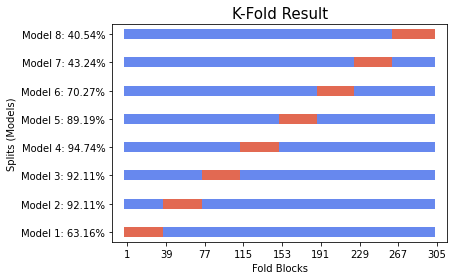

In [268]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def display_graph():
    fig, ax = plt.subplots()
    xl_step = round(x_train.shape[0] / len(parameters_score))

    for index, info in enumerate(parameters_score):
        indices = np.array([np.nan] * x_train.shape[0])
        indices[info['test_indexes']] = 1
        indices[info['train_indexes']] = 0
        ax.scatter(range(len(indices)), [index + .5] * len(indices), c=indices, marker='_', lw=10, cmap=plt.cm.coolwarm, vmin=-.2, vmax=1.2)

    ax.set(xticks=[xl_step * i for i in range(len(parameters_score) + 1)],
           xticklabels=[xl_step * i + 1 for i in range(len(parameters_score) + 1)],
           yticks=np.arange(len(parameters_score)) + .5, 
           yticklabels=[f'Model {i + 1}: {round(parameters_score[i]["score"] * 100, 2)}%' for i in range(len(parameters_score))],
           xlabel='Fold Blocks', 
           ylabel='Splits (Models)')
    ax.set_title('K-Fold Result', fontsize=15)

display_graph()

df_results_2 = pd.DataFrame([[r['params'], r['score']] for r in parameters_score], columns=['Params', 'Accuracy Score'])
df_results_2 = df_results_2.sort_values(by=['Accuracy Score'], ascending=False)

selected_best_params = df_results_2.values[0][0]

display(HTML(df_results_2.to_html()))

## 4. Display results

==== Display results for Training data =====
Accuracy score:  0.9166666666666666
Confusion matrix:
          Actual 0  Actual 1
Pred. 0       171        18
Pred. 1         7       104


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


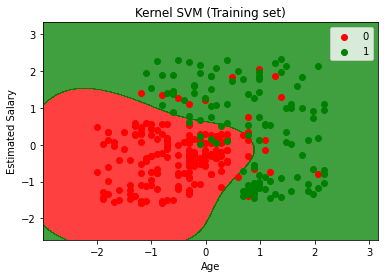

==== Display results for Test data =====
Accuracy score:  0.93
Confusion matrix:
          Actual 0  Actual 1
Pred. 0        64         4
Pred. 1         3        29


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


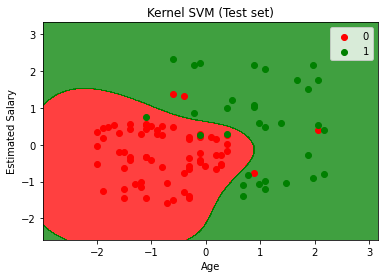

In [280]:
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.colors import ListedColormap

model.set_params(**selected_best_params)
model.fit(x_train, y_train)


def display_details(x_set, y_set, data_type):
    print(f'==== Display results for {data_type} data =====')

    y_set_pred = model.predict(x_set)
    cm = confusion_matrix(y_set, y_set_pred)

    print('Accuracy score: ', accuracy_score(y_set, y_set_pred))
    print('Confusion matrix:\n', pd.DataFrame(cm, columns=['Actual 0', 'Actual 1'], index=['Pred. 0', 'Pred. 1']))

    x1, x2 = np.meshgrid(np.arange(start=x_set[:, 0].min() - 1, stop=x_set[:, 0].max() + 1, step=0.01),
                         np.arange(start=x_set[:, 1].min() - 1, stop=x_set[:, 1].max() + 1, step=0.01))

    plt.contourf(x1, x2, model.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape), alpha=0.75, cmap=ListedColormap(('red', 'green')))
    plt.xlim(x1.min(), x1.max())
    plt.ylim(x2.min(), x2.max())

    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(x_set[y_set == j, 0], x_set[y_set == j, 1], c=ListedColormap(('red', 'green'))(i), label=j)
    plt.title(f'Kernel SVM ({data_type} set)')
    plt.xlabel('Age')
    plt.ylabel('Estimated Salary')
    plt.legend()
    plt.show()
    
display_details(x_train, y_train, 'Training')
display_details(x_test, y_test, 'Test')